# Mapping loneliness area scores from GP points, Wales 2022

### Check venv is activated

In [1]:
import sys
import os
if sys.base_prefix != sys.prefix:
    venv_name = os.path.basename(sys.prefix)
    print(f"You are in a virtual environment - {venv_name}")
else:
    print("You are not in a virtual environment. Activate your venev")

You are in a virtual environment - venv_loneliness


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from shapely.geometry import Point
import rasterio as rst
from rasterstats import zonal_stats

## Join GPs postcodes to coordinates

- Get coordinates for postcodes in the UK
- https://geoportal.statistics.gov.uk/datasets/9ac0331178b0435e839f62f41cc61c16

*File needs to be manually downloaded*

In [3]:
nspl = pd.read_csv("C:/Users/JennaTan/Downloads/NSPL_MAY_2022_UK.csv", low_memory = False)

In [4]:
nspl.head(2)

,pcd,pcd2,pcds,dointr,doterm,usertype,oseast1m,osnrth1m,osgrdind,oa11,...,ru11ind,oac11,lat,long,lep1,lep2,pfa,imd,calncv,stp
0,AB1 0AA,AB1 0AA,AB1 0AA,198001,199606.0,0,385386.0,801193.0,1,S00090303,...,3,1C3,57.101474,-2.242851,S99999999,S99999999,S23000009,6715,S99999999,S99999999
1,AB1 0AB,AB1 0AB,AB1 0AB,198001,199606.0,0,385177.0,801314.0,1,S00090303,...,3,1C3,57.102554,-2.246308,S99999999,S99999999,S23000009,6715,S99999999,S99999999


In [5]:
nspl = nspl[["pcds", "oseast1m", "osnrth1m", "lsoa11", "msoa11" ]]
nspl["pcds"] = nspl.pcds.str.replace(" ", "")

In [6]:
# Read loneliness scores by GP df
df = pd.read_csv("../../extdata/wales_gp_2022.csv")

In [7]:
print(len(df))
df.head(2)

475


,postcode,loneliness_zscore
0,CF834AU,2.394639
1,LL113NS,0.923323


In [8]:
df.rename(columns = {"postcode":"pcds"}, inplace = True)

In [9]:
df = df.merge(nspl, on = "pcds", how = "left")

In [10]:
# Check all postcodes have matched - there is one that hasnt
df.isna().value_counts()

pcds   loneliness_zscore  oseast1m  osnrth1m  lsoa11  msoa11
False  False              False     False     False   False     474
                          True      True      True    True        1
Name: count, dtype: int64

In [11]:
# investigate postcode that didn't match - could be data entry error o instead of 0
df[df.msoa11.isna()]

,pcds,loneliness_zscore,oseast1m,osnrth1m,lsoa11,msoa11
365,LD3OAW,0.151096,NaN,NaN,NaN,NaN


In [12]:
nspl[nspl.pcds=="LD30AW"]

,pcds,oseast1m,osnrth1m,lsoa11,msoa11
1246366,LD30AW,315492.0,234175.0,W01000494,W02000111


In [13]:
# drop it for now
df.dropna(inplace = True)

## Read DF as Geopanda

In [14]:
# CRS =  EPSG 27700, reads gpd as British National Grid coords
# Create a new col 'geometry'

geo_data = gpd.GeoDataFrame(data = df, 
                            crs = {'init':'epsg:27700'}, 
                            geometry = df.apply(lambda geom: Point(geom['oseast1m'],geom['osnrth1m']),axis=1))
geo_data.head()

C:\Users\JennaTan\Documents\loneliness\venv_loneliness\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,pcds,loneliness_zscore,oseast1m,osnrth1m,lsoa11,msoa11,geometry
0,CF834AU,2.394639,312091.0,189331.0,W01001331,W02000307,POINT (312091.000 189331.000)
1,LL113NS,0.923323,328624.0,351132.0,W01000364,W02000083,POINT (328624.000 351132.000)
2,CH51XS,-9.339888,330760.0,367615.0,W01000335,W02000066,POINT (330760.000 367615.000)
3,NP447XX,-9.481488,329326.0,193774.0,W01001504,W02000335,POINT (329326.000 193774.000)
4,NP447XX,-5.242755,329326.0,193774.0,W01001504,W02000335,POINT (329326.000 193774.000)


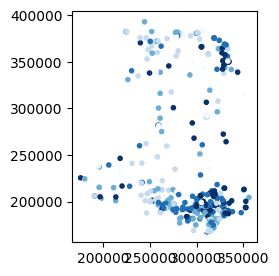

In [15]:
# Visualise loneliness score geographically using geometry col
geo_data.plot(column = 'loneliness_zscore', scheme = 'quantiles', cmap = 'Blues', marker = '.', figsize=(3,3));

- Reflects shape of Wales
- Not very evenly distributed - quite a few gaps in the middle; with huge cluster around Cardiff area
- Darker dots higher levels of loneliness - expect to see replication - in south east and north east

## Develop KNN; predict unknown points

### Instantiate KNN as IDW model

In [16]:
def idw_model(k, p):
    """
    Instantiates a KNN regressor as an IDW interpolater. k = no. neighbours, p = power for idw
    """
    def _inv_distance_index(weights, index=p):
        """Weights set as distance from the input points and neighbour, with an inverse calculation of (1/dist**power).
        Values not dividable by 0 are ignored.
        """
        #return (test==0).astype(int) if np.any(weights == 0) else 1. / weights**index
        
        with np.errstate(divide='ignore', invalid='ignore'):
            safe_weights = 1. / weights**index
        return np.nan_to_num(safe_weights, posinf=0) # ignore weights that are negative
        
    return KNeighborsRegressor(k, weights=_inv_distance_index)

### Train test split

In [30]:
# Get existing point locations and values to fit the model
points = geo_data[['oseast1m','osnrth1m']].values
vals = geo_data['loneliness_zscore'].values

In [31]:
np.isnan(points).sum()

0

In [32]:
len(vals)

474

In [33]:
X_train, X_test, y_train, y_test = train_test_split(points, vals, test_size=0.2, random_state=42)

### Find best k and p

In [34]:
param_grid = {
    'n_neighbors': [ 5, 6, 7, 8, 9, 10],
    'p': [1, 1.5, 2, 2.5, 3]
}

knn_model = idw_model(1,1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(knn_model, param_grid, cv=kf)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(n_neighbors=1,
                                           weights=<function idw_model.<locals>._inv_distance_index at 0x00000202BCC125E0>),
             param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10],
                         'p': [1, 1.5, 2, 2.5, 3]})

In [35]:
best_k = grid_search.best_params_['n_neighbors']
best_p = grid_search.best_params_['p']

print("Best k:", best_k)
print("Best p:", best_p)

Best k: 10
Best p: 1.5


In [37]:
grid = idw_model(10,1.5).fit(X_train, y_train)
original = idw_model(5,2).fit(X_train, y_train)

y_pred_grid = grid.predict(X_test)
y_pred_original = original.predict(X_test)

In [38]:
print(f" Grid Search MSE: {mean_squared_error(y_test, y_pred_grid)}")
print(f" Original params MSE: {mean_squared_error(y_test, y_pred_original)}")

 Grid Search MSE: 21.759521089655234
 Original params MSE: 22.713657155004597


### Use best params to fit model

In [63]:
idw = idw_model(5, 1).fit(points, vals)

### Create grid of values to predict

In [64]:
# Get minimum and maximum coords from the data
print("xmin = ", geo_data['oseast1m'].min(), "\n\r",
      "xmax = ", geo_data['oseast1m'].max(), "\n\r",
      "ymin = ", geo_data['osnrth1m'].min(), "\n\r",
      "ymax = ", geo_data['osnrth1m'].max())

xmin =  175485.0 
 xmax =  356308.0 
 ymin =  167517.0 
 ymax =  393061.0


In [66]:
xmin =  175485.0 
xmax =  356308.0 
ymin =  167517.0  
ymax =  393061.0

In [67]:
def grid(xmin, xmax, ymin, ymax, cellsize):
    """
    Creates an evenly spaced grid structure of all possible x and y coords within the bounds of the data that will be 
    used for prediction. Even spacing ensures reliable and uniform coverage of the surface for estimation.
    
    """
    # Adjust x and y ranges to be perfectly divisible by cellsize using floor and ceiling division, ensuring even spacing
    xmin = (xmin // cellsize) * cellsize 
    xmax = -(-xmax // cellsize) * cellsize 
    ymin = (ymin // cellsize) * cellsize
    ymax = -(-ymax // cellsize) * cellsize
    
    # Generate coords within adjusted min/max range with regular spacing determined by cellsize
    x = np.linspace(xmin,xmax,int((xmax-xmin)/cellsize))
    y = np.linspace(ymin,ymax,int((ymax-ymin)/cellsize))
    
    # Create grid structure of all possible x and y points, returns two 2D arrays
    xx,yy = np.meshgrid(x,y)
   
    return xx, yy

In [68]:
# cellsize = 250 represents BNG 250m x 250m square
xx,yy = grid(xmin, xmax, ymin, ymax, 200 )

In [69]:
def reshape_grid(xx,yy):
    """ 
    Reshape output of the meshgrid into a single array combining x and y coords.
    Ravel flattens xx/yy into (1,n) and [] turns it into a col vector (n,1). 
    Two col vectors combined to form xy
    """
    return np.append(xx.ravel()[:,np.newaxis],yy.ravel()[:,np.newaxis],1)

In [70]:
xy = reshape_grid(xx,yy)

### Predict unknown values using trained KNN model

In [71]:
# Predict values in the grid. Returns 1D array, (n,1)
scores = idw.predict(xy)

In [72]:
scores.shape

(1021745,)

### Reshape predictions to grid

- KNN Regresor outputs a 1D array - predictions per coordinate
- It needs to be reshaped to 2D to allign with the xx,yy meshgrid

In [73]:
def reshape_image(scores, xx):
    return np.flip(scores.reshape(np.shape(xx)),0)

scores = reshape_image(scores, xx)

In [74]:
scores.shape == xx.shape

True

### Inspect surface outcome

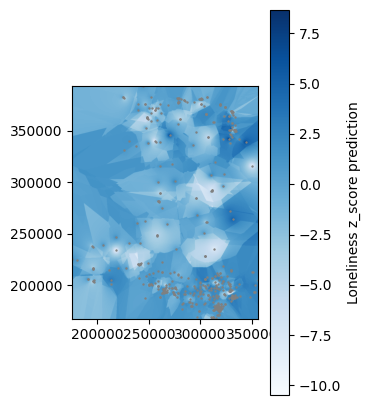

In [75]:
f, ax = plt.subplots(figsize = (3,5))
#ax.imshow(z, cmap='Reds')
#ax.set_aspect('equal')

heatmap = ax.imshow(scores, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax.scatter(points[:, 0], points[:, 1], color='grey', s=0.5)
cbar = plt.colorbar(heatmap, ax=ax, label='Loneliness z_score prediction')


Darker areas around the cities; roughly matches

## Map to LSOA- 1,917 in Wales

- Get shape files : https://geoportal.statistics.gov.uk/datasets/766da1380a3544c5a7ca9131dfd4acb6_0/about
- Calculate zonal stats 

In [83]:
# Get Super Data Zones which we use to aggregate the z score variable.
filestring = r'C:/Users/JennaTan/Downloads/LSOA_2021/LSOA_2021_EW_BGC.shp'

lsoa = gpd.read_file(filestring)
lsoa.to_crs({'init':'epsg:27700'}).head(5) # projects coordinates onto British National Grid

# Filter for Wales only
lsoa = lsoa[lsoa.LSOA21CD.str.startswith('W')]

C:\Users\JennaTan\Documents\loneliness\venv_loneliness\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [85]:
# Check there are 1917
lsoa.LSOA21CD.nunique()

1917

In [86]:
# Affine transformation maps pixels from the KNN estimates to spatial coordinates of each IZ's geometry in BNG space
# 250 = pixels resolution (size of each pixel in x/y direction) = 250mx250m
# 125 = spatial alignment in x/y direction = centres 

trans = rst.Affine.from_gdal(xmin-100,200,0,ymax+100,0,-200)

In [90]:
# Get the mean predicted score based on MSOA polygon shape, returns a dictionary
lsoa_zone = zonal_stats(lsoa['geometry'], scores, affine = trans, stats = 'mean', nodata = np.nan)

In [91]:
# Extract score from dictionary, turn into a list and add as col in .shp
lsoa['loneliness_zscore'] = list(map(lambda x: x['mean'] , lsoa_zone))

<Axes: >

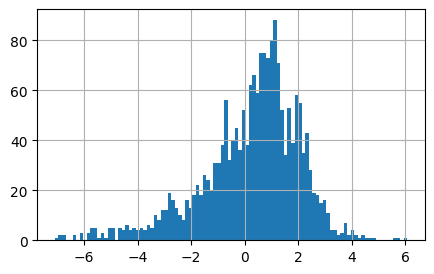

In [92]:
lsoa['loneliness_zscore'].hist(bins = 100, figsize = (5,3))

In [93]:
lsoa['loneliness_zscore'].isna().value_counts()

loneliness_zscore
False    1912
True        5
Name: count, dtype: int64

In [94]:
lsoa["rank"] = lsoa["loneliness_zscore"].rank()
lsoa["deciles"] = pd.qcut(lsoa["loneliness_zscore"], q=10, labels=False)

C:\Users\JennaTan\AppData\Local\Temp\ipykernel_25208\2756048554.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu', len(decile_values))


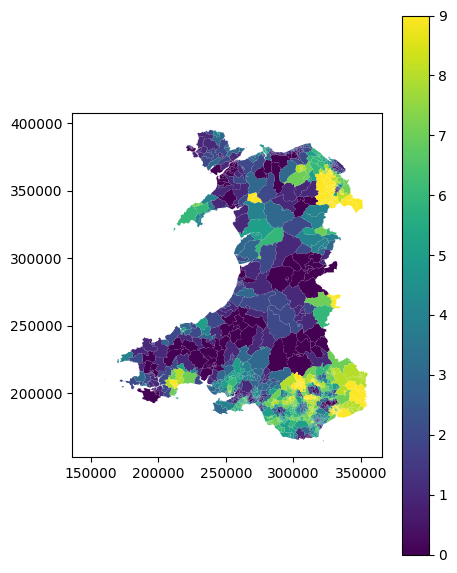

In [95]:
from matplotlib.patches import Patch
import matplotlib.cm as cm

decile_values = lsoa['deciles'].unique()

# Automatically generate colors based on the number of unique decile values
cmap = cm.get_cmap('RdYlBu', len(decile_values))

# Create the legend handles for each decile range
handles = []
for i, decile in enumerate(decile_values):
    col = cmap(i)
    handles.append(Patch(facecolor=col, label=f"Decile {decile}"))

# Create the plot of Wales map with the decile colors
fig, ax = plt.subplots(figsize=(5, 7))
lsoa.plot(column='deciles', ax=ax, legend=True);


There are 5 LSOAs with missing values

#### Investigate missing values

In [97]:
# Investigate missing values
lsoa[lsoa.loneliness_zscore.isna() == True]

,LSOA21CD,LSOA21NM,GlobalID,geometry,loneliness_zscore,rank,deciles
34742,W01001059,Vale of Glamorgan 015A,2f8dfcac-a3db-451d-b266-2247fddef9d1,"POLYGON ((310329.242 167278.770, 310378.649 16...",NaN,NaN,NaN
34743,W01001060,Vale of Glamorgan 015B,87df6f6f-baa2-4518-a76b-025041dc27cb,"POLYGON ((309349.879 167368.245, 309609.187 16...",NaN,NaN,NaN
34798,W01001117,Vale of Glamorgan 014B,e99e9282-abe1-49f6-80de-6fcfec5fad0f,"POLYGON ((304808.120 167183.019, 304829.078 16...",NaN,NaN,NaN
35631,W01001998,Vale of Glamorgan 015G,9470fdc3-a528-4eb7-a2fc-c137f6017c8f,"MULTIPOLYGON (((310386.559 166089.038, 310367....",NaN,NaN,NaN
35670,W01002039,Vale of Glamorgan 014H,453d12bf-dc81-4daf-a21a-6135a84caaca,"POLYGON ((306820.271 166519.139, 306844.281 16...",NaN,NaN,NaN


In [98]:
# check all postcodes fall within boundaires of the sdz geometry
intersections = gpd.overlay(geo_data, lsoa, how='intersection')
len(intersections['pcds']) 

472

Total postcodes are 230 so all GP postcodes have been assigned an SDZ

In [99]:
# Check if any of the GP postcodes call within the missing SDZ
code = ['W01001059', 'W01001060', 'W01001117', 'W01001998', 'W01002039' ]

for c in code:
    intersections = gpd.overlay(geo_data, lsoa[lsoa['LSOA21CD']==c], how='intersection')
    print(len(intersections['pcds']))


0
0
0
0
0


- SDZs without scores don't have GP postcodes within its catchment area explaining the no data. 
- There are 317 active GPs in NI in March 2023 so unlikely Gps have been missed out from preproc script.
- Although seems unusual that 3 SDZ would not have a GP
- Can impute missing values or leave as NA